# To plot the periodogram of FRB20201130A

In [4]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

from astropy.timeseries import LombScargle
from astropy.time import Time

DATAPATH = os.getenv('DATAPATH')
CATALOG_PATH = Path(DATAPATH, 'raw', 'catalog2023', 'catalog2023_profile.parquet')
CATALOG_PATH_CSV = Path(DATAPATH, 'raw', 'catalog2023', 'chimefrb2023repeaters.csv')
CATALOG1_PATH_PARQUET = Path(DATAPATH, 'catalog_1.parquet')

cat1 = pd.read_parquet(CATALOG1_PATH_PARQUET)[["eventname","repeater_name", "mjd_400"]]
cat1['catalog'] = 'Catalog 1'
cat2023 = pd.read_csv(CATALOG_PATH_CSV)[["tns_name","repeater_name","mjd_400"]].rename(columns={'tns_name':'eventname'})
cat2023['catalog'] = 'Catalog 2023'
data = pd.concat([cat1, cat2023])
data['mjd'] = data['mjd_400']
data

,eventname,repeater_name,mjd_400,catalog,mjd
0,FRB20180725A,-9999,58324.749803,Catalog 1,58324.749803
1,FRB20180727A,-9999,58326.036262,Catalog 1,58326.036262
2,FRB20180729A,-9999,58328.033565,Catalog 1,58328.033565
3,FRB20180729B,-9999,58328.728032,Catalog 1,58328.728032
4,FRB20180730A,-9999,58329.151134,Catalog 1,58329.151134
...,...,...,...,...,...
146,FRB20210313E,FRB20201221B,59286.202113,Catalog 2023,59286.202113
147,FRB20210331F,FRB20210323C,59304.147737,Catalog 2023,59304.147737
148,FRB20210331F,FRB20210323C,59304.147737,Catalog 2023,59304.147737
149,FRB20210426B,FRB20210323C,59330.091835,Catalog 2023,59330.091835


In [5]:
# chosen_name = 'FRB20201130A' # (13)
# chosen_name = 'FRB20180916B' # (77)
# chosen_name = 'FRB20190915D' # 👍 (10)
# chosen_name = 'FRB20200929C' # (10)
chosen_name = 'FRB20190804E' # 👍 (10)
# chosen_name = 'FRB20191106C' # 👍 (7)
# chosen_name = 'FRB20201221B'
selected = data[['repeater_name', 'mjd', 'catalog']].sort_values(by='mjd')
selected[chosen_name] = (selected['repeater_name'] == chosen_name).astype(int)

In [6]:
kwargs = dict(
    minimum_frequency=0,
    maximum_frequency=1,
    samples_per_peak=1_000
)

LS = LombScargle(selected['mjd'].to_numpy(), selected[chosen_name].to_numpy())
freq, power = LS.autopower(**kwargs)

LS_Window = LombScargle(selected['mjd'].to_numpy(), 1)
freq_window, power_window = LS_Window.autopower(**kwargs)

false_alarm_level = LS.false_alarm_level(0.01)

periodogram = pd.DataFrame({'period': 1/freq, 'power': power, 'freq': freq, 'power_window': power_window})

/home/tazaaznam/lab/sarjana/.venv/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/tmp/ipykernel_1126/3601994225.py:15: RuntimeWarning: divide by zero encountered in divide
  periodogram = pd.DataFrame({'period': 1/freq, 'power': power, 'freq': freq, 'power_window': power_window})


In [7]:
# Estimate error using leave one out resampling

detections = selected.loc[selected[chosen_name] == 1].index

kwargs = dict(
    minimum_frequency=0,
    maximum_frequency=1,
    samples_per_peak=100
)

best_freqs = []
for idx in detections:
    reduced = selected.loc[selected.index != idx]
    LS = LombScargle(reduced['mjd'].to_numpy(), reduced[chosen_name].to_numpy())
    freq, power = LS.autopower(**kwargs)
    best_freqs.append(freq[np.nanargmax(power)])

stats = pd.DataFrame(1/np.array(best_freqs)).describe()

/home/tazaaznam/lab/sarjana/.venv/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/home/tazaaznam/lab/sarjana/.venv/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: invalid value encountered in divide
  power = YC * YC / CC + YS * YS / SS


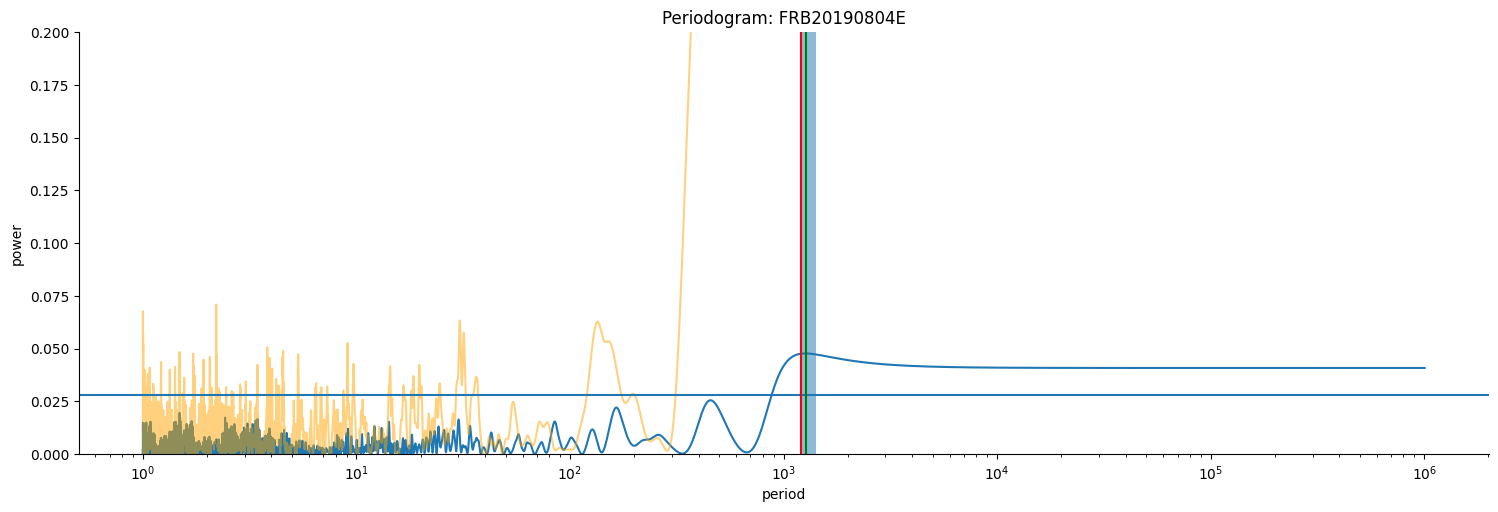

In [8]:
import seaborn as sns

xaxis = 'period'

G = sns.relplot(periodogram,x=xaxis, y='power', aspect=3, kind='line')
sns.lineplot(periodogram, x=xaxis, y='power_window', color='orange', alpha=0.5, ax=G.ax)
G.ax.axhline(false_alarm_level)
G.ax.axvline(1/freq[np.nanargmax(power)], color='red')
G.ax.axvline(stats.loc['mean'].item(), color='green')
G.ax.axvspan(stats.loc['min'].item(), stats.loc['max'].item(), alpha=0.5)
_=G.ax.set(ylim=(0,0.2), xscale='log', title=f'Periodogram: {chosen_name}')

[Text(0.5, 1.0, 'Count distribution: FRB20190804E')]

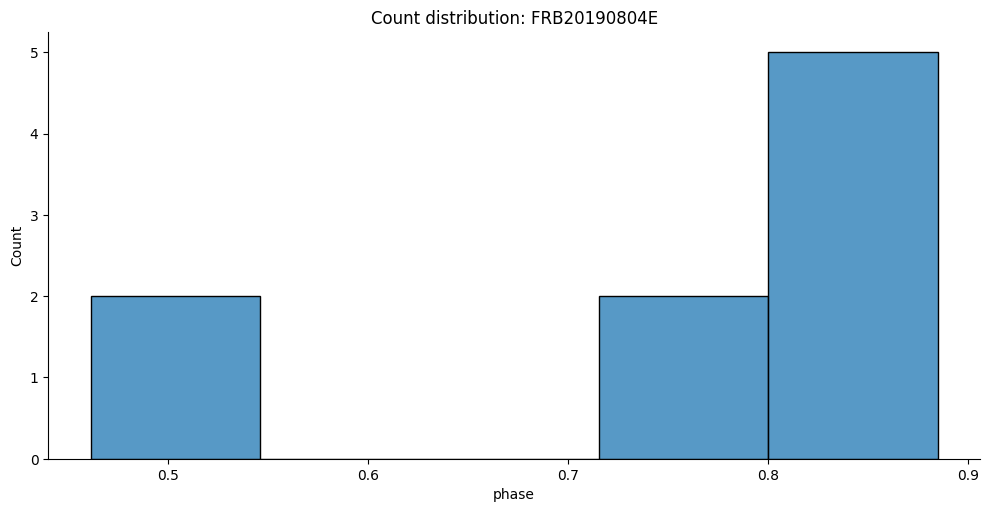

In [9]:
period = 1/freq[np.nanargmax(power)]
# period = 100405.557443
selected['phase'] = (selected['mjd'] / period) % 1
g = sns.displot(selected.loc[selected[chosen_name] == 1], x='phase', aspect=2)
# sns.kdeplot(selected.loc[selected[chosen_name] == 1], x='phase')
g.ax.set(title=f'Count distribution: {chosen_name}')

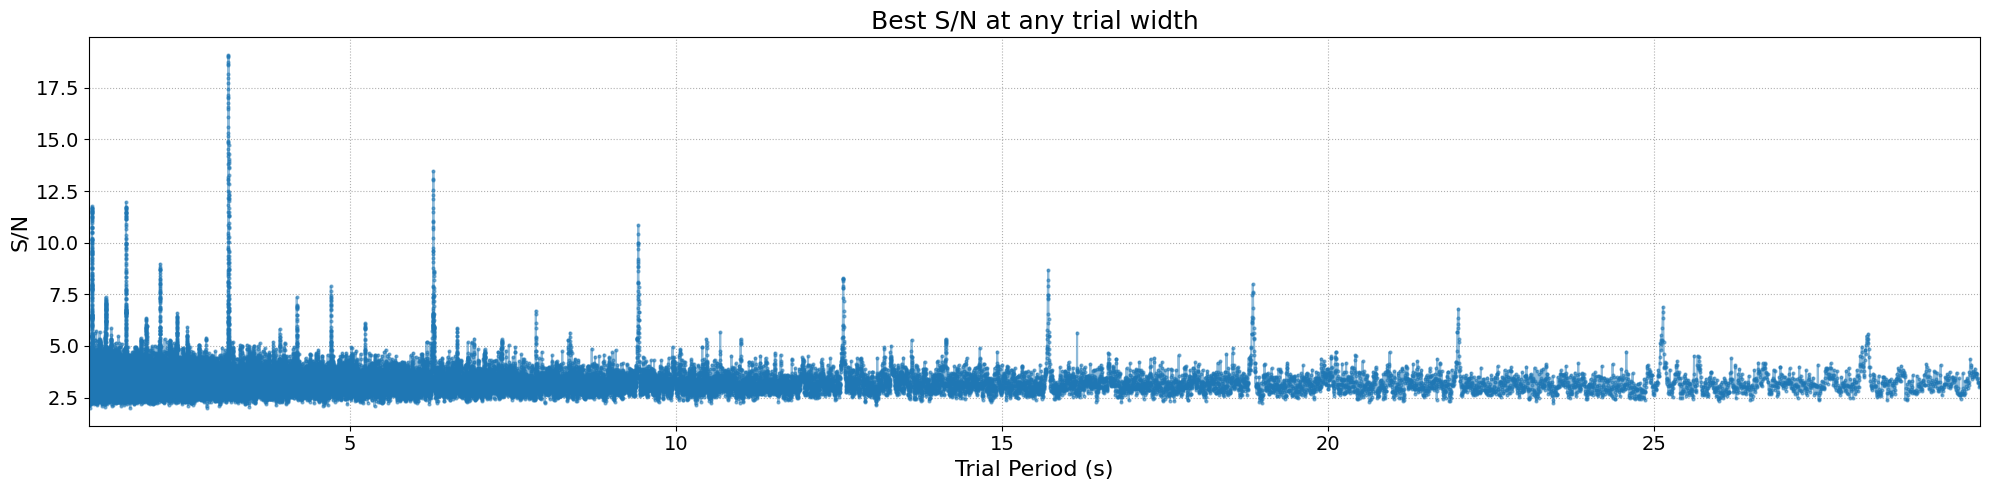

In [10]:
from riptide import TimeSeries, ffa_search

t = TimeSeries.generate(length=600.0, tsamp=256e-6, period=3.14159, ducy=0.02, amplitude=20.0)

ts, prgrm = ffa_search(t)

prgrm.display()

In [11]:
t.metadata

Metadata {'dm': None,
 'fname': None,
 'mjd': None,
 'signal_duty_cycle': 0.02,
 'signal_initial_phase': 0.5,
 'signal_period': 3.14159,
 'signal_shape': 'Von Mises',
 'skycoord': None,
 'source_name': 'fake',
 'tobs': 600.0}

In [12]:
import astropy
import pandas as pd

table = pd.read_table(
    Path(DATAPATH, 'raw', 'external', 'FRB121102A-Rajwade2020.txt'), sep="|", skiprows=1
    )
table.columns = [i.strip() for i in table.columns]
mjd = table['MJD'].dropna(axis=0)
det = pd.DataFrame(pd.Series(astropy.time.Time(mjd, format='mjd').to_datetime()), columns=['MJD'])
# det.groupby(
#     by=pd.Grouper(level=0, freq='12h')
#     )
det['detection'] = 1

day_in_sec = 60*60*24
t_frb = TimeSeries(det.set_index('MJD').resample('d').count()['detection'].to_numpy(), tsamp=day_in_sec)

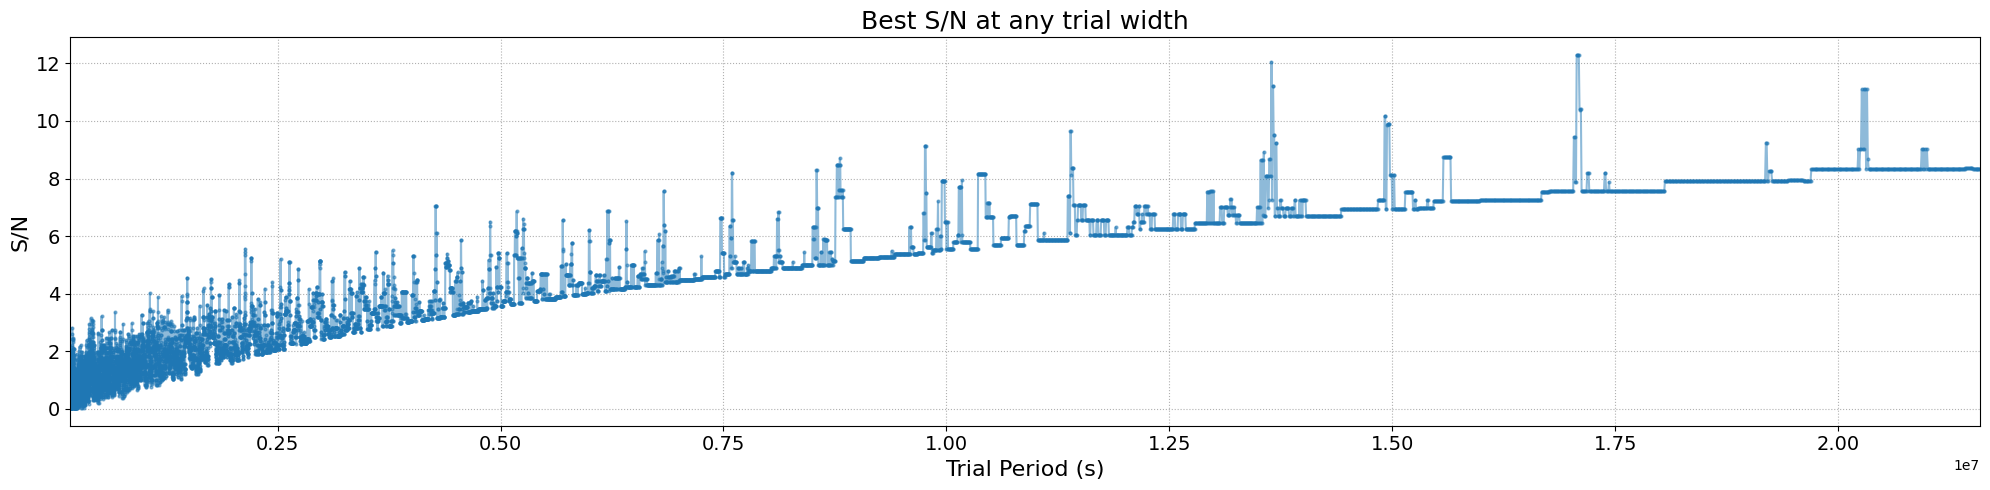

In [13]:
min_bin = 2
tn, pdgm = ffa_search(t_frb, period_min=min_bin*day_in_sec, period_max=250*day_in_sec, bins_min=min_bin, deredden=False)

pdgm.display()

In [14]:
def calc_inactive_fraction(timeseries: TimeSeries, period: float, width: int) -> float:
    phases = timeseries.fold(period, width).sum(axis=0)
    counts = []
    cnt = 0
    for item in phases:
        if item != 0:
            counts.append(cnt)
            cnt = 0
        else:
            cnt += 1

    if counts == []:
        counts.append(0)
    return np.max(counts) / len(phases)

def trial_periods_inactive_frac(timeseries: TimeSeries,x_axis: np.ndarray, bins: np.ndarray) -> np.ndarray:
    frac = []
    for i, widths in zip(x_axis, bins):
        frac.append(calc_inactive_fraction(timeseries, i, int(0.99*widths)))
    return np.array(frac)

In [15]:
frac=trial_periods_inactive_frac(t_frb, x_axis:=pdgm.periods, pdgm.foldbins)

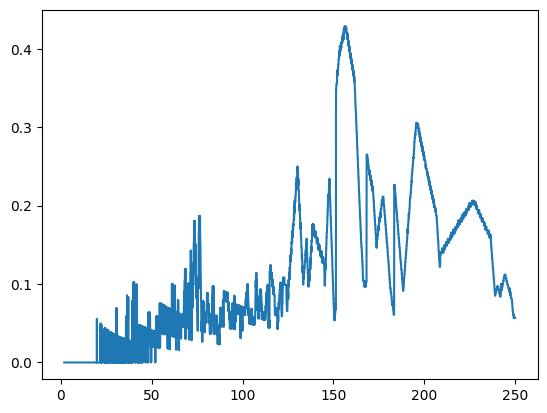

In [16]:
import matplotlib.pyplot as plt

plt.plot(x_axis/day_in_sec, frac)

In [17]:
x_axis[np.nanargmax(frac)]

13489929.85457656

In [18]:
import astropy
import pandas as pd

table = pd.read_table(
    Path(DATAPATH, 'raw', 'external', 'FRB121102A-Rajwade2020.txt'), sep="|", skiprows=1
    )
table.columns = [i.strip() for i in table.columns]
mjd = table['MJD'].dropna(axis=0)
det = pd.DataFrame(pd.Series(astropy.time.Time(mjd, format='mjd').to_datetime()), columns=['MJD'])
# det.groupby(
#     by=pd.Grouper(level=0, freq='12h')
#     )
det['detection'] = 1

day_in_sec = 60*60*24
t_frb = TimeSeries(det.set_index('MJD').resample('d').count()['detection'].to_numpy(), tsamp=day_in_sec)
min_bin = 2
tn, pdgm = ffa_search(t_frb, period_min=min_bin*day_in_sec, period_max=250*day_in_sec, bins_min=min_bin, deredden=False)

trial_periods_inactive_frac(t_frb,x_axis:=pdgm.periods, pdgm.foldbins)

array([0.        , 0.        , 0.        , ..., 0.05691057, 0.05691057,
       0.05691057])

/tmp/ipykernel_1126/1557648266.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  timeseries = TimeSeries(t:=selected.set_index('datetime').resample('d').sum()[chosen_name].to_numpy(), tsamp=day_in_sec)
/tmp/ipykernel_1126/1557648266.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  _s = selected.groupby('mjd').sum()
/home/tazaaznam/lab/sarjana/.venv/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:138: RuntimeWarning: invalid value encountered in log
  power = -np.log(1 - power / YY)


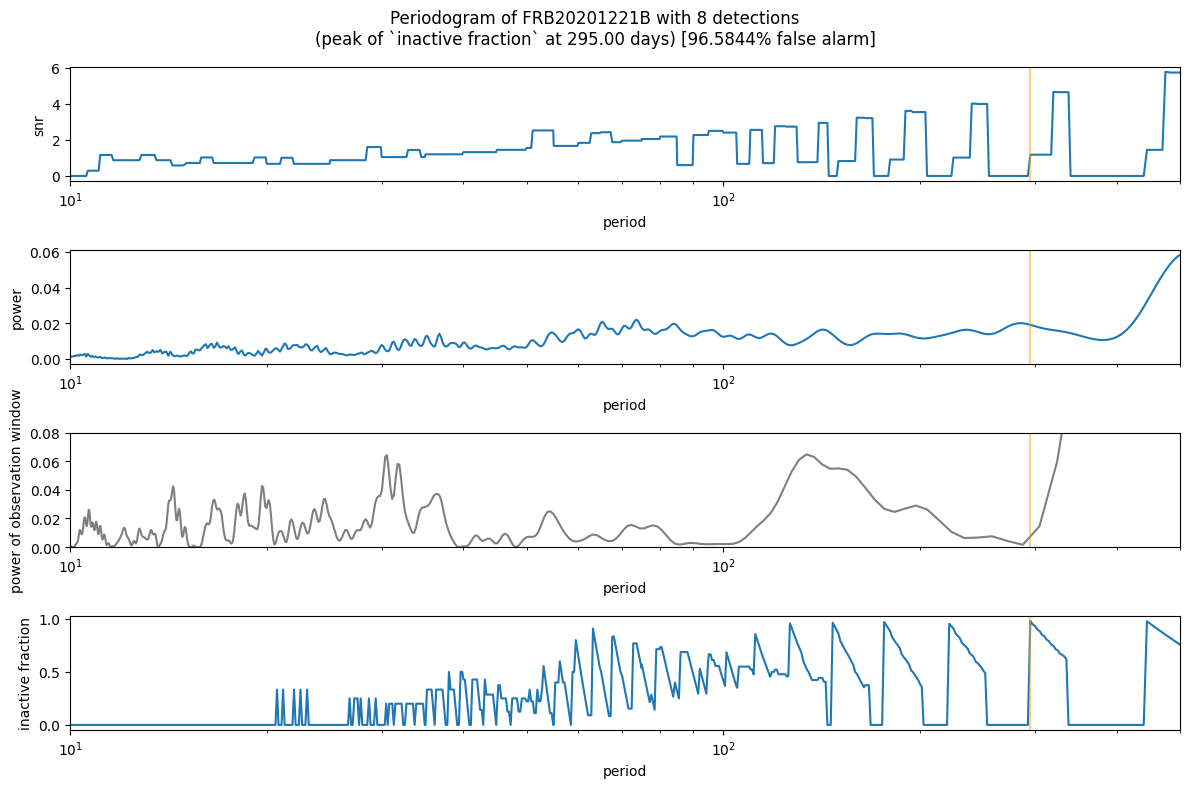

In [33]:
# chosen_name = 'FRB20201130A' # (13)
# chosen_name = 'FRB20180916B' # (77)
# chosen_name = 'FRB20190915D' # 👍 (10)
# chosen_name = 'FRB20200929C' # (10)
# chosen_name = 'FRB20190804E' # 👍 (10)
# chosen_name = 'FRB20191106C' # 👍 (7)
chosen_name = 'FRB20201221B' # (8)
# measure = 'power'
measure = 'frac'
selected = data[['repeater_name', 'mjd', 'catalog']].sort_values(by='mjd')
selected[chosen_name] = (selected['repeater_name'] == chosen_name).astype(int)
detections = selected[chosen_name].sum()
selected['datetime'] = astropy.time.Time(selected['mjd'], format='mjd').to_datetime()
timeseries = TimeSeries(t:=selected.set_index('datetime').resample('d').sum()[chosen_name].to_numpy(), tsamp=day_in_sec)
t_n, pdgram = ffa_search(timeseries, period_min=1e1*day_in_sec, period_max=1e5*day_in_sec, bins_min=2, deredden=False)
frac = trial_periods_inactive_frac(timeseries, x_axis:=pdgram.periods, pdgram.foldbins)

selected['datetime'] = astropy.time.Time(selected['mjd'], format='mjd').to_datetime()
_s = selected.groupby('mjd').sum()

kwargs = dict(
    minimum_frequency=0,
    maximum_frequency=1,
    samples_per_peak=1_000
)

LS = LombScargle(_s.index.to_numpy(), _s[chosen_name].to_numpy(), normalization='log')
power = LS.power(freq:=(np.sort(pdgram.freqs)*day_in_sec))

LS_Window = LombScargle(selected['mjd'].to_numpy(), 1, normalization='log')
freq_window, power_window = LS_Window.autopower()

false_alarm_level = LS.false_alarm_level(0.01)

periodogram = pd.DataFrame(
    {'period': 1/freq, 'power': power, 'freq': freq, 'snr': pdgram.snrs[::-1].flatten(), 'frac': frac[::-1]}
    )
periodogram.replace([np.inf, -np.inf], np.nan, inplace=True)
period = periodogram.loc[periodogram[measure] == periodogram[measure].max(), 'period'].item()
prob = LS.false_alarm_probability(periodogram.loc[periodogram['period'] == period,'power'].item())

import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4,1)

fig.set_figheight(8)
fig.set_figwidth(12)

sns.lineplot(periodogram, x='period', y='snr', ax=axs[0])

sns.lineplot(periodogram, x='period', y='power', ax=axs[1])

sns.lineplot(x=1/freq_window, y=power_window, ax=axs[2], color='black', alpha=0.5)
axs[2].set_ylim(0,0.08)
axs[2].set_ylabel('power of observation window')
axs[2].set_xlabel('period')

sns.lineplot(periodogram, x='period', y='frac', ax=axs[3])
axs[3].set_ylabel('inactive fraction')

for i in range(4):
    axs[i].semilogx()
    axs[i].set_xlim(periodogram['period'].min(), periodogram['period'].max())
    axs[i].axvline(period, color='orange', alpha=0.5)

longname = {
    'frac': 'inactive fraction',
    'power': 'power'
}

plt.suptitle(f'Periodogram of {chosen_name} with {detections} detections\n(peak of `{longname[measure]}` at {period:.2f} days) [{100*prob:.4f}% false alarm]')
fig.set_tight_layout('tight')
fig.savefig(f'{chosen_name}-periodogram-{measure}.png')

AttributeError: 'DataFrame' object has no attribute 'display'

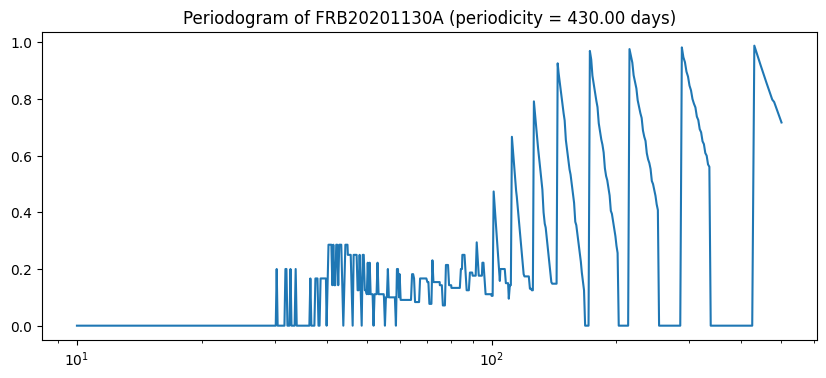

In [20]:

plt.figure(figsize=(10,4))
plt.plot(x_axis/day_in_sec, frac)
# plt.axvline(period:=x_axis[np.nanargmax(frac)]/day_in_sec, color='red')
plt.title(f'Periodogram of {chosen_name} (periodicity = {period:.2f} days)')
plt.semilogx()
# plt.plot(selected.set_index('datetime').resample('d').count().index, t, '.')
periodogram.display()
plt.savefig(f'{chosen_name}.png')

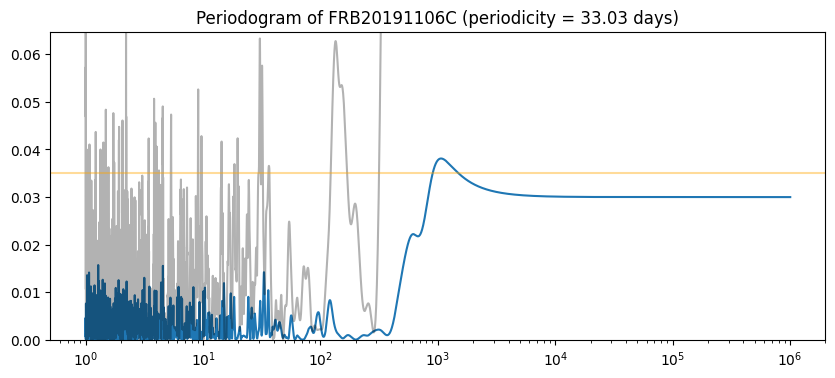

In [ ]:
plt.figure(figsize=(10,4))
plt.gca().set_ylim(0, periodogram['power'].max()*1.7)
plt.plot(periodogram['period'], periodogram['power'])
plt.plot(periodogram['period'], periodogram['power_window'], color='black', alpha=0.3)
plt.semilogx()
plt.axhline(false_alarm_level, color='orange', alpha=0.4)
# plt.axvline(period:=x_axis[np.nanargmax(frac)]/day_in_sec, color='red')
plt.title(f'Periodogram of {chosen_name} (periodicity = {period:.2f} days)')
plt.savefig(f'{chosen_name}-lomb-scargle.png')